[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_09/MISIS4825_Laboratorio09_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 09 – Taller: Detección de Objetos con YOLO

## Introducción

En este taller trabajaremos con el tema de la **detección de objetos**, que consiste en localizar y clasificar múltiples objetos dentro de una imagen. Esta técnica tiene aplicaciones en diversos campos, como:

- **Seguridad**: detección de personas, rostros o vehículos en sistemas de videovigilancia.  
- **Automoción**: identificación de peatones y señales de tránsito en vehículos autónomos.  
- **Agricultura**: conteo de plantas o frutos en imágenes aéreas.  
- **Medicina**: localización de anomalías en imágenes médicas como radiografías o resonancias magnéticas.  

El algoritmo **YOLO** (*You Only Look Once*) es conocido por realizar detecciones en tiempo real mediante una sola pasada de la imagen. Desde su primera versión en 2016, ha evolucionado hasta **YOLOv11**, que introduce mejoras en la arquitectura y en la velocidad de entrenamiento.

## Objetivos

1. **Entender la arquitectura de YOLO** y sus componentes principales (*Backbone*, *Neck* y *Head*).  
2. **Preparar un conjunto de datos** en formato YOLO para entrenamiento.  
3. **Entrenar un modelo YOLOv11** utilizando un dataset de detección de animales.  
4. **Evaluar el rendimiento del modelo** mediante métricas como mAP50 y mAP50–95.  
5. **Explorar configuraciones avanzadas** como variantes del modelo (*nano*, *small*, *medium*) y ajustes de hiperparámetros.  


**Datos:** [multiclass-animal-detection](https://www.kaggle.com/datasets/notaashman/multiclass-animal-detection)

## 1. Descarga y Preparación del Dataset

In [1]:
import os
import json

In [2]:
# Instalación de Kaggle
!pip install kaggle --quiet

In [3]:
# Cargar credenciales desde kaggle.json
with open('kaggle.json', 'r') as f:
    kaggle_creds = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

# Descargar y descomprimir
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files(
    'notaashman/multiclass-animal-detection',
    path='data',
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/notaashman/multiclass-animal-detection


## 2. Exploración de Datos

El conjunto de datos está organizado en tres particiones principales: `train`, `valid` y `test`. Cada partición contiene dos subcarpetas:

- `images/`: Contiene las imágenes en formato `.jpg` o `.png`.  
- `labels/`: Contiene las etiquetas en formato `.txt`, donde cada archivo describe las clases y las coordenadas de las cajas delimitadoras (*bounding boxes*).  

       count
train   1400
valid    300
test     300


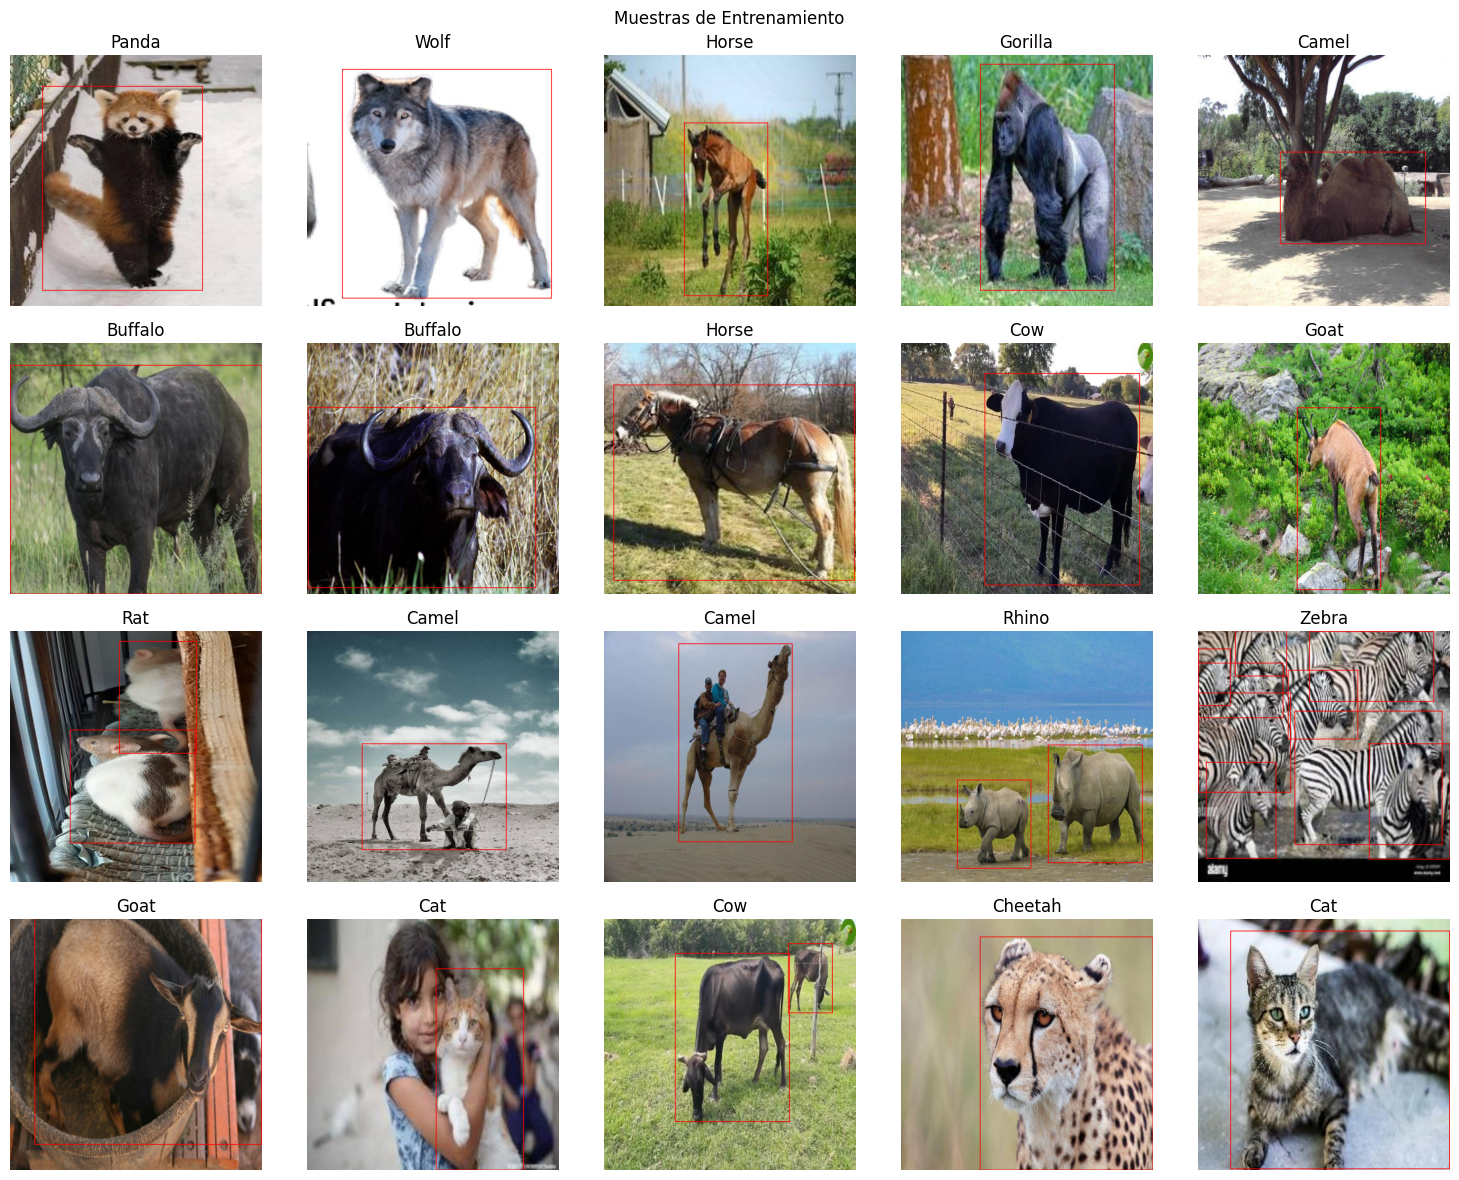

In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

DATA_ROOT = Path('data') / 'Multi-Class Animal Detection.v1-yolov8'
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {DATA_ROOT}")

root = DATA_ROOT
train_img = root / 'train' / 'images'
train_lbl = root / 'train' / 'labels'

# Definir clases
class_names = [
    "Buffalo", "Camel", "Cat", "Cheetah", "Cow", "Deer", "Dog", "Elephant",
    "Goat", "Gorilla", "Hippo", "Horse", "Lion", "Monkey", "Panda", "Rat",
    "Rhino", "Tiger", "Wolf", "Zebra"
]

# 1. Conteo de imágenes y distribución numérica
counts = {}
for split in ['train', 'valid', 'test']:
    path = root / split / 'images'
    counts[split] = len(list(path.glob('*.*'))) if path.exists() else 0

# Mostrar tabla de distribución
dist = pd.Series(counts, name='count')
print(dist.to_frame())

# 2. Visualizar muestras con bounding boxes y título de clase
population = list(train_img.glob('*.*'))
if not population:
    raise FileNotFoundError(f"No se encontraron imágenes en {train_img}")

# Tomar hasta 20 muestras
k = min(20, len(population))
sample_images = random.sample(population, k)

n_cols = 5
n_rows = (k + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

for ax, img_path in zip(axes.flatten(), sample_images):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    lbl_path = train_lbl / f"{img_path.stem}.txt"
    title_labels = set()
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            cls, x_c, y_c, bw, bh = map(float, line.split())
            # Convertir a coordenadas de pixeles
            cx, cy = x_c * w, y_c * h
            bw_pix, bh_pix = bw * w, bh * h
            x1, y1 = cx - bw_pix/2, cy - bh_pix/2
            x2, y2 = cx + bw_pix/2, cy + bh_pix/2
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            title_labels.add(class_names[int(cls)])

    ax.imshow(img)
    ax.set_title(", ".join(sorted(title_labels)) or "Sin etiqueta")
    ax.axis('off')

# Ocultar ejes sobrantes
for ax in axes.flatten()[k:]:
    ax.axis('off')

plt.suptitle('Muestras de Entrenamiento')
plt.tight_layout()
plt.show()

## 3. Preprocesamiento y YAML

En esta sección, se realiza la configuración necesaria para que el modelo YOLO pueda utilizar el conjunto de datos. Esto incluye:

1. **Definición de las clases**: Se especifican las categorías de objetos que el modelo debe detectar. En este caso, las clases corresponden a diferentes tipos de animales, como "Buffalo", "Camel", "Cat", entre otros.

2. **Creación del archivo YAML**: Este archivo es esencial para entrenar modelos YOLO, ya que define la estructura del conjunto de datos. Contiene información como:
   - La ruta base del conjunto de datos.
   - Las particiones de entrenamiento, validación y prueba.
   - El número total de clases (`nc`).
   - Los nombres de las clases (`names`).

El archivo YAML asegura que el modelo pueda interpretar correctamente las imágenes y etiquetas durante el entrenamiento y la evaluación.

In [5]:
# Crear animal-detection.yaml
yaml_content = f"""
path: {DATA_ROOT.absolute()}
train: train/images
val:   valid/images
test:  test/images

nc: {len(class_names)}
names: {class_names}
""".strip()
with open(DATA_ROOT / 'animal-detection.yaml', 'w') as f:
    f.write(yaml_content)

## 4 Arquitectura de YOLO

YOLO (“You Only Look Once”) cambió el paradigma de la detección de objetos al combinar en una sola red la localización y clasificación de instancias, evitando las etapas separadas de propuestas y refinamiento de métodos como R-CNN. Fue introducido por Redmon et al. en 2016 en *“You Only Look Once: Unified, Real-Time Object Detection”* ([ver paper](https://arxiv.org/abs/1506.02640)). Su flujo de datos se compone de:

1. **Backbone**  
   Una CNN profunda que extrae mapas de características a varios niveles de abstracción. En las familias modernas de YOLO suele emplearse CSPDarknet, que reduce la redundancia de gradiente y acelera el entrenamiento.

2. **Neck**  
   Una red de agregación multiescala (por ejemplo PANet o BiFPN) que fusiona los mapas del Backbone para capturar tanto objetos pequeños como grandes de forma eficiente.

3. **Head**  
   La capa final divide el mapa en una cuadrícula y, para cada celda, predice varias cajas delimitadoras, su confianza y la distribución de clases. Aplica Non-Max Suppression para filtrar solapamientos.

> A modo de ejemplo, la siguiente ilustración muestra el esquema general de YOLOv11, con sus tres bloques principales:
>  
> ![Arquitectura YOLOV11](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*L8rMuwurmyBH1ixIqcrMSQ.png)  

### Variantes de YOLOv11

Para distintos balances de velocidad y precisión, YOLOv11 ofrece cinco tamaños preentrenados:

| Variante      | Parámetros aproximados | Uso recomendado                         |
|---------------|------------------------|-----------------------------------------|
| **v11n** (nano)   | ~2.6 M                   | Dispositivos edge, prototipado rápido    |
| **v11s** (small)  | ~9.4 M                   | Móviles, aplicaciones con recursos limitados |
| **v11m** (medium) | ~20.1 M                  | GPU de nivel medio, tareas generales     |
| **v11l** (large)  | ~25.3 M                  | Servidores potentes, máxima precisión     |
| **v11x** (XL)     | ~56.9 M                  | Investigación o despliegue en datacenter  |

En este laboratorio emplearemos **YOLOv11s**, que ofrece un buen compromiso entre velocidad de entrenamiento, latencia de inferencia y calidad de detección.


# 5. Entrenamiento del Modelo

Entrenaremos la variante **small** de YOLOv11 en el conjunto de datos de detección de animales.

Para obtener el modelo preentrenado de las diferentes variantes de YOLOv11, tenemos las siguientes opciones:

- `yolo11n.pt` — **nano**
- `yolo11s.pt` — **small**
- `yolo11m.pt` — **medium**
- `yolo11l.pt` — **large**
- `yolo11x.pt` — **extra large**

In [6]:
!pip install ultralytics --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Cargar modelo base (small)
model = YOLO('yolo11s.pt')

# Entrenar
results = model.train(
    data=str(root / 'animal-detection.yaml'),
    epochs=20,
    imgsz=640,
    batch=16,
    patience=5,
    name='animal_yolov11s'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 213MB/s]


Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=data/Multi-Class Animal Detection.v1-yolov8/animal-detection.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=animal_yolov11s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 26.2MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1    827148  ultralytics.nn.modules.head.Detect           [20, [128, 256, 512]]         
YOLO11s summary: 181 layers, 9,435,532 parameters, 9,435,516 gradients, 21.6 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 94.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 22.7±4.9 MB/s, size: 47.7 KB)


train: Scanning /content/data/Multi-Class Animal Detection.v1-yolov8/train/labels... 1400 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1400/1400 [00:02<00:00, 660.91it/s]

train: New cache created: /content/data/Multi-Class Animal Detection.v1-yolov8/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.8±9.4 MB/s, size: 40.5 KB)


val: Scanning /content/data/Multi-Class Animal Detection.v1-yolov8/valid/labels... 300 images, 1 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 578.62it/s]

val: New cache created: /content/data/Multi-Class Animal Detection.v1-yolov8/valid/labels.cache


Plotting labels to runs/detect/animal_yolov11s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/animal_yolov11s
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.05G      1.034      3.835       1.51         26        640: 100%|██████████| 88/88 [00:31<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        300        412      0.457      0.408      0.339      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.85G      1.031      2.376      1.469         26        640: 100%|██████████| 88/88 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300        412      0.497      0.454      0.454      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.87G      1.063      2.056      1.483         25        640: 100%|██████████| 88/88 [00:27<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300        412      0.377      0.463      0.428      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.91G      1.057      1.948      1.491         21        640: 100%|██████████| 88/88 [00:27<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


                   all        300        412       0.56      0.572      0.599      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.95G      1.057      1.846      1.486         24        640: 100%|██████████| 88/88 [00:27<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

                   all        300        412      0.672      0.496      0.609      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.99G     0.9946      1.659      1.445         31        640: 100%|██████████| 88/88 [00:27<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

                   all        300        412      0.688      0.571      0.643      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.04G     0.9656      1.545      1.417         24        640: 100%|██████████| 88/88 [00:27<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        300        412      0.749      0.539      0.653      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.08G     0.9582      1.451      1.402         24        640: 100%|██████████| 88/88 [00:27<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        300        412      0.656      0.569       0.63      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.12G     0.9393      1.412      1.383         26        640: 100%|██████████| 88/88 [00:27<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

                   all        300        412      0.673      0.619      0.686      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.16G      0.943       1.38      1.397         18        640: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        300        412      0.746      0.627      0.743      0.514


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       5.2G     0.8142      1.107       1.39          8        640: 100%|██████████| 88/88 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

                   all        300        412      0.762      0.692      0.771      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.24G     0.7933      0.907      1.371          9        640: 100%|██████████| 88/88 [00:26<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        300        412      0.785      0.689      0.763      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.28G     0.7368     0.8416      1.321          9        640: 100%|██████████| 88/88 [00:26<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        300        412      0.787      0.675      0.763      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.31G      0.712     0.7495      1.288          9        640: 100%|██████████| 88/88 [00:27<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

                   all        300        412      0.856      0.712      0.815      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.36G     0.6742     0.6843      1.246          8        640: 100%|██████████| 88/88 [00:26<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        300        412      0.815      0.734      0.821      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       5.4G     0.6502     0.6109      1.241          8        640: 100%|██████████| 88/88 [00:26<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

                   all        300        412      0.782      0.783      0.819      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.44G     0.6257     0.5565      1.209          9        640: 100%|██████████| 88/88 [00:26<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

                   all        300        412      0.822       0.76      0.838      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.47G        0.6     0.4965       1.18          9        640: 100%|██████████| 88/88 [00:26<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

                   all        300        412      0.862      0.783      0.858      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.52G     0.5864     0.4776      1.151         19        640: 100%|██████████| 88/88 [00:26<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

                   all        300        412      0.819      0.788       0.86      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.55G     0.5693     0.4612      1.154         13        640: 100%|██████████| 88/88 [00:26<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


                   all        300        412      0.842      0.812      0.859      0.666

20 epochs completed in 0.174 hours.
Optimizer stripped from runs/detect/animal_yolov11s/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/animal_yolov11s/weights/best.pt, 19.2MB

Validating runs/detect/animal_yolov11s/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,420,540 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


                   all        300        412      0.824      0.787       0.86      0.666
               Buffalo         15         23      0.768      0.721      0.762      0.622
                 Camel         15         20      0.802       0.65       0.82      0.569
                   Cat         15         17      0.637      0.765      0.804      0.647
               Cheetah         15         25      0.907       0.78      0.875      0.602
                   Cow         15         17      0.917      0.647      0.867      0.741
                  Deer         15         15      0.964      0.867      0.939      0.739
                   Dog         15         17      0.886      0.913       0.97      0.731
              Elephant         15         23       0.93      0.739       0.88      0.694
                  Goat         15         22      0.762      0.583      0.798      0.577
               Gorilla         15         17      0.776      0.824      0.805      0.645
                 Hipp

# 6. Evaluación del modelo

YOLO guarda las curvas de entrenamiento y la matriz de confusión en `runs/detect/animal_yolov11s/`.

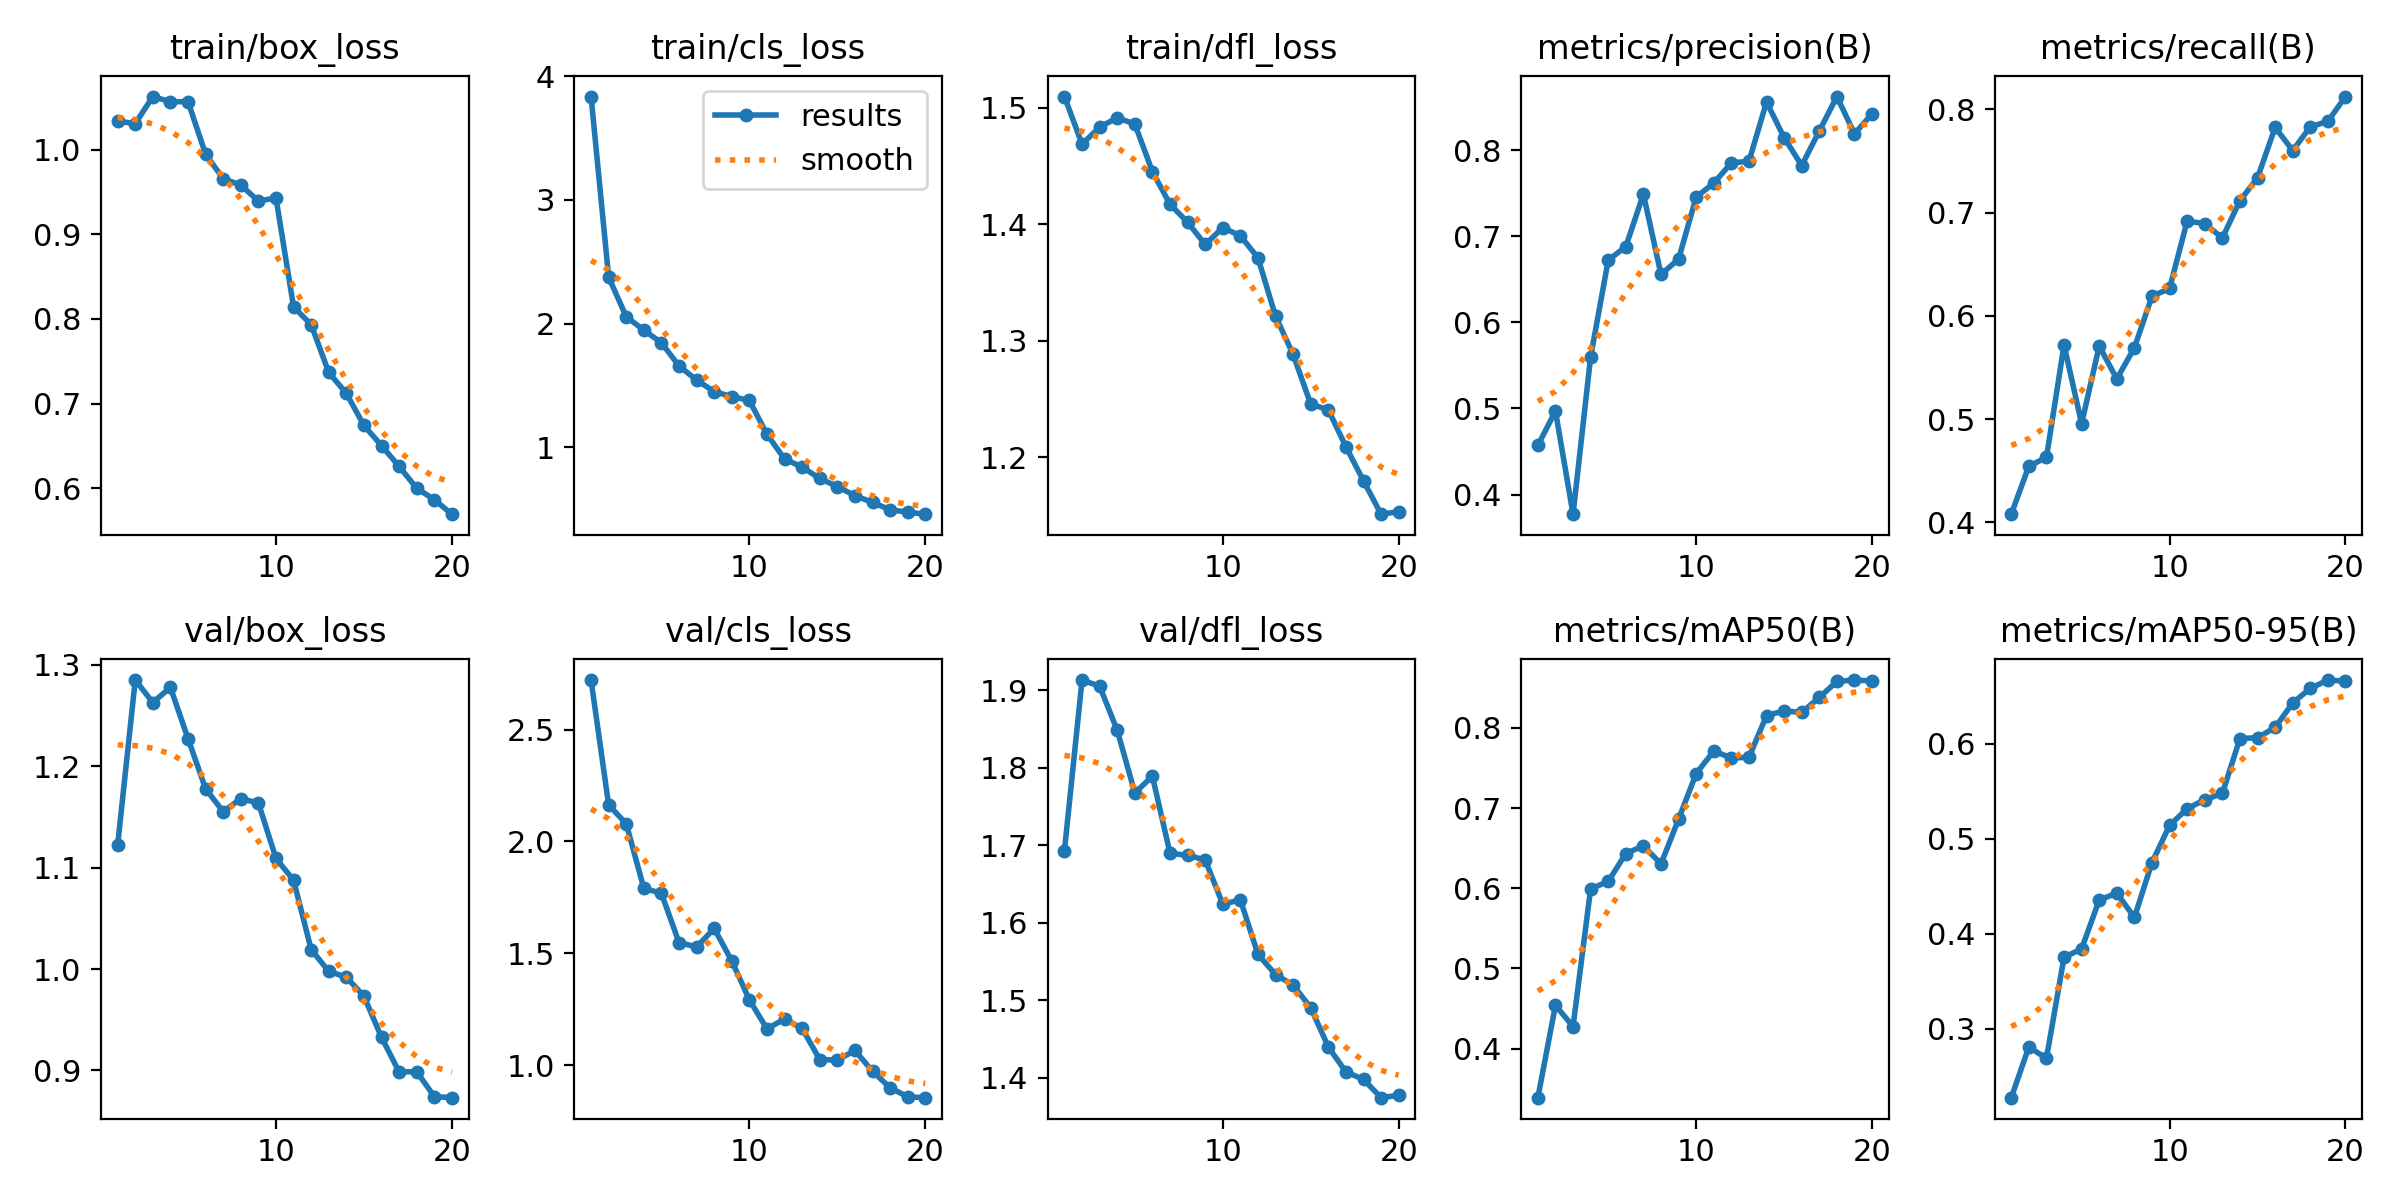

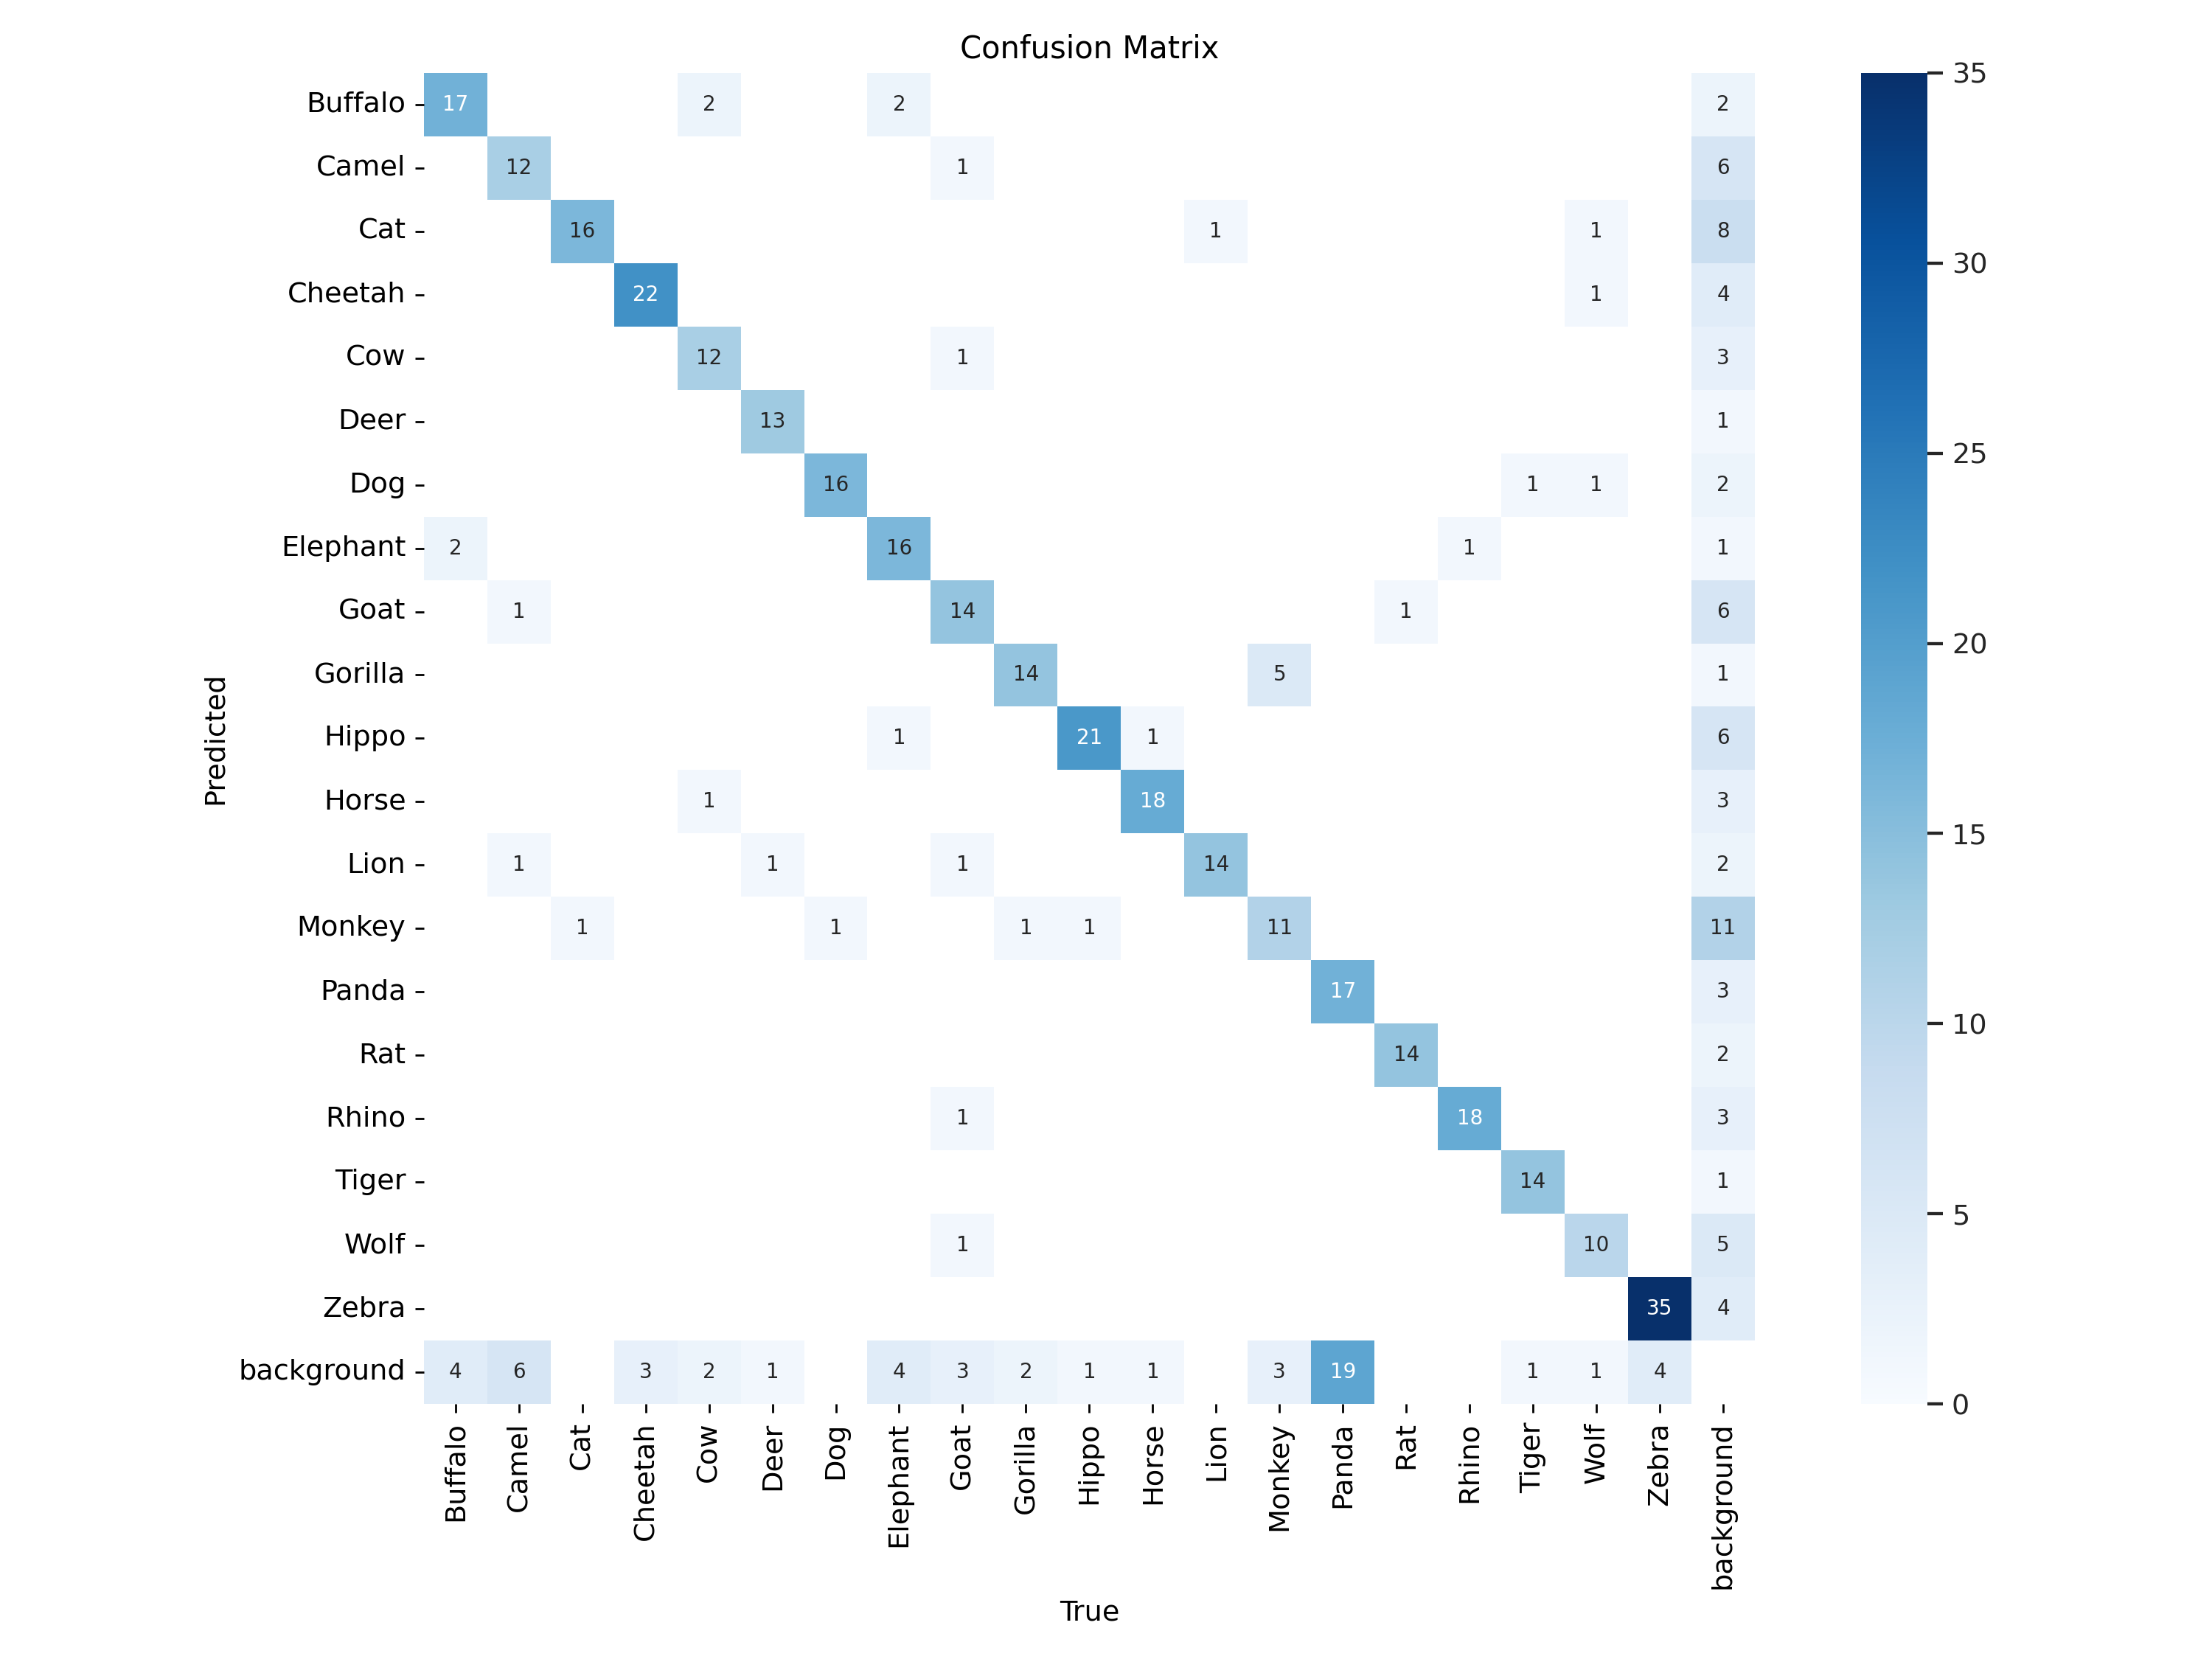

In [8]:
# Mostrar curva de mAP y loss
from PIL import Image as PImage
display(PImage.open('runs/detect/animal_yolov11s/results.png'))

# Matriz de confusión
display(PImage.open('runs/detect/animal_yolov11s/confusion_matrix.png'))

# 7. Predicción / Inferencia

Results saved to runs/detect/animal_yolov11s_predict3


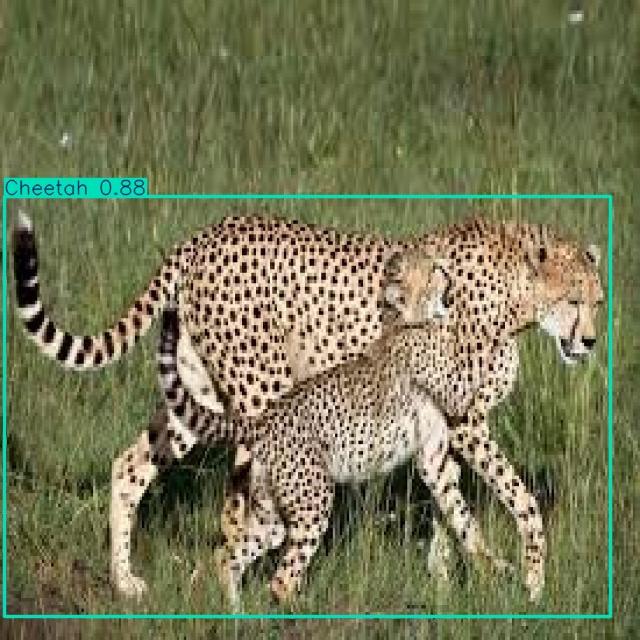

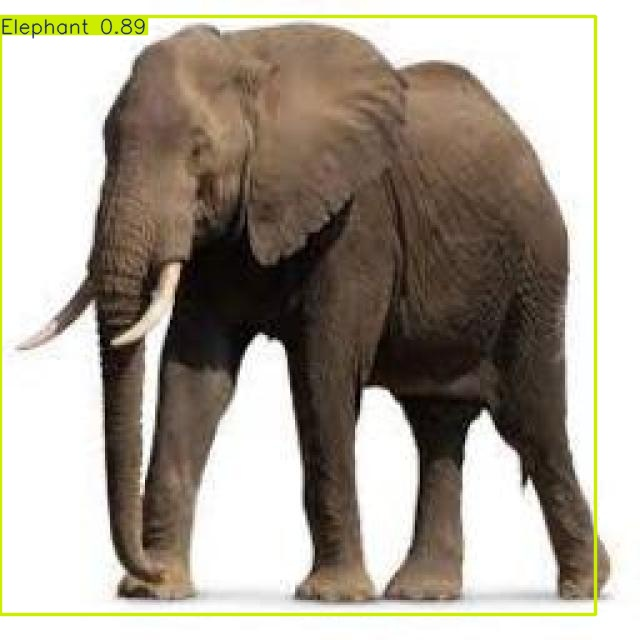

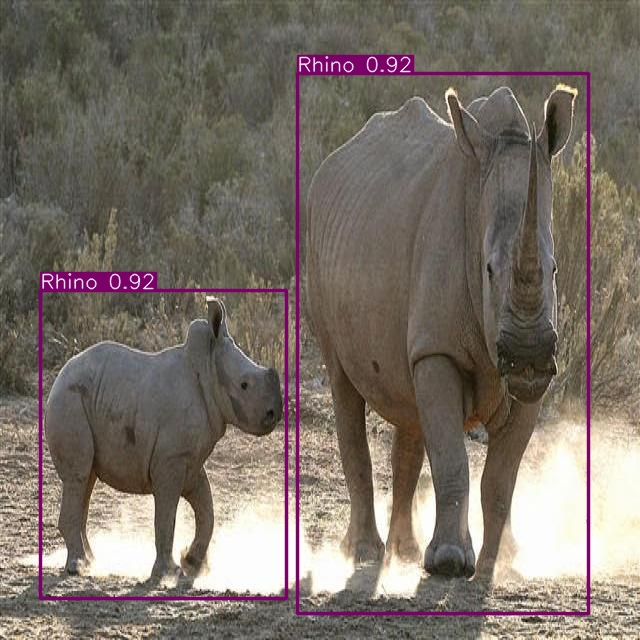

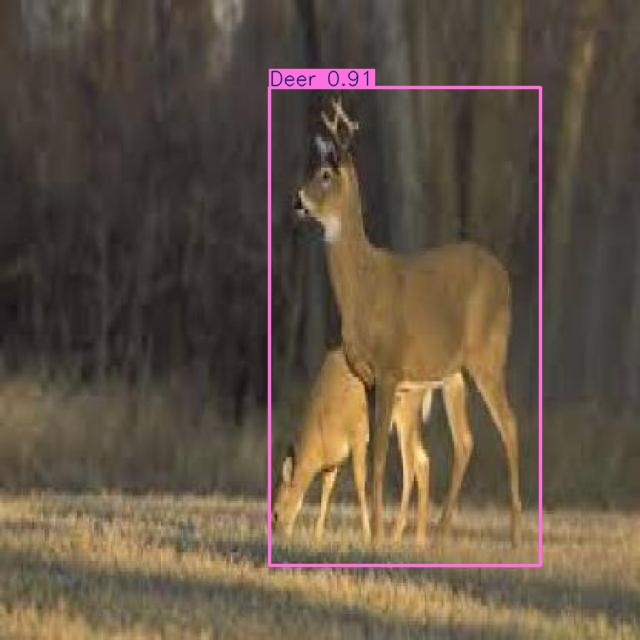

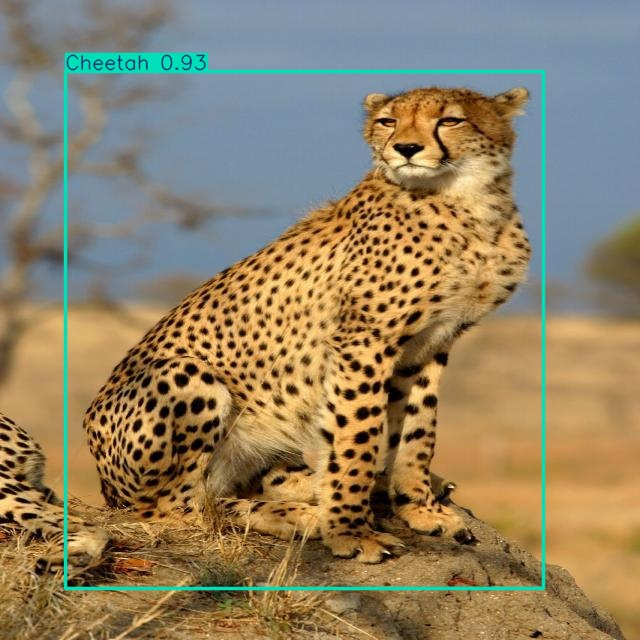

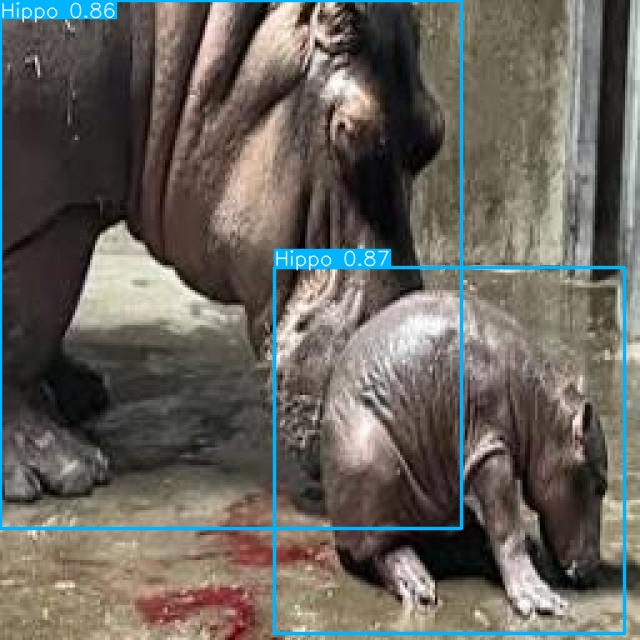

In [11]:
# Inferencia
preds = model.predict(
    source=str(root / 'test' / 'images'),
    conf=0.25,
    save=True,
    name='animal_yolov11s_predict',
    verbose=False  # Suprimir mensajes en la consola
)

# Mostrar algunas predicciones
import glob
import random
from IPython.display import display

files = glob.glob('runs/detect/animal_yolov11s_predict/*.jpg')
for img in random.sample(files, 6):
    display(PImage.open(img))

## 8. Conclusiones y Discusión

1. **Velocidad vs. Precisión:**  
   - Comparar los tiempos de entrenamiento e inferencia entre las variantes `yolo11s` (small) y `yolo11n` (nano).  
   - ¿En qué escenarios es más conveniente usar cada variante (nano, small, medium, large, extra-large)? Cantidad de datos, recursos computacionales, etc.

2. **mAP50 vs. mAP50–95:**  
   - ¿Qué significa que mAP50 evalúe solo intersecciones sobre uniones (IoU) mayores o iguales a 0.5?  
   - ¿Qué información adicional proporciona evaluar el rango mAP50–95 al medir el rendimiento del modelo?

3. **Hiperparámetros críticos:**  
   - ¿Cómo afectan los valores de `batch` (tamaño de lote), `imgsz` (tamaño de imagen) y `patience` (paciencia para detener el entrenamiento) al tiempo de entrenamiento, uso de memoria y convergencia del modelo?

4. **Data Augmentation:**  
   - ¿Qué técnicas de aumento de datos podrían mejorar la capacidad del modelo para generalizar en diferentes escenarios?